## Importar librerías

In [1]:
import pandas as pd                                # Para manipulación de datos
from pandas_profiling import ProfileReport         # Para exploración automática
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\David Sanchez\AppData\Local\Temp\ipykernel_10484\802039147.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport         # Para exploración automática


## Cargar el dataset

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# 1. Verificar dimensiones
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")

Dataset cargado con 7043 filas y 21 columnas.


# I. DESCRIPCIÓN DE NECESIDADES DE LIMPIEZA

## 1. Duplicados totales

In [3]:
dup_count = df.duplicated().sum()
print(f"1️⃣ Duplicados totales: {dup_count}")
if dup_count:
    # ¿En qué customerID aparecen?
    dup_ids = df[df.duplicated(subset=["customerID"], keep=False)]["customerID"].unique()
    print("  • customerID duplicados:", dup_ids.tolist())
print()

1️⃣ Duplicados totales: 0



## 2. Valores nulos y cadenas vacías

In [4]:
blank_counts = df.isnull().sum() + df.astype(str)\
    .apply(lambda col: col.str.strip().eq("")).sum()
print("\n2️⃣ Valores nulos / vacíos por columna:")
print(blank_counts[blank_counts > 0])


2️⃣ Valores nulos / vacíos por columna:
TotalCharges    11
dtype: int64


## 3. Inconsistencias en valores (revisa categorías)

In [5]:
print("\n3️⃣ Valores únicos por columna categórica (muestra primeras 5):")
for col in df.select_dtypes(include="object").columns:
    uniques = df[col].unique()
    if len(uniques) < 10:
        print(f"   • {col}: {uniques}")


3️⃣ Valores únicos por columna categórica (muestra primeras 5):
   • gender: ['Female' 'Male']
   • Partner: ['Yes' 'No']
   • Dependents: ['No' 'Yes']
   • PhoneService: ['No' 'Yes']
   • MultipleLines: ['No phone service' 'No' 'Yes']
   • InternetService: ['DSL' 'Fiber optic' 'No']
   • OnlineSecurity: ['No' 'Yes' 'No internet service']
   • OnlineBackup: ['Yes' 'No' 'No internet service']
   • DeviceProtection: ['No' 'Yes' 'No internet service']
   • TechSupport: ['No' 'Yes' 'No internet service']
   • StreamingTV: ['No' 'Yes' 'No internet service']
   • StreamingMovies: ['No' 'Yes' 'No internet service']
   • Contract: ['Month-to-month' 'One year' 'Two year']
   • PaperlessBilling: ['Yes' 'No']
   • PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
   • Churn: ['No' 'Yes']


## 4. Tipos de datos actuales

In [6]:
print("\n4️⃣ Tipos de dato originales:")
print(df.dtypes)


4️⃣ Tipos de dato originales:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


## 5. Valores atípicos

In [7]:
num_cols = df.select_dtypes(include=["int64","float64"]).columns
outliers = {}
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    mask = ~df[col].between(low, high)
    outliers[col] = mask.sum()
print("\n5️⃣ Conteo de outliers por variable numérica:")
print(outliers)


5️⃣ Conteo de outliers por variable numérica:
{'SeniorCitizen': np.int64(1142), 'tenure': np.int64(0), 'MonthlyCharges': np.int64(0)}


#

## 6. Nivel de granularidad

In [8]:
granularity = df.groupby("tenure").size()
print(f"\n6️⃣ Granularidad: hay {len(granularity)} niveles de 'tenure' distintos.")


6️⃣ Granularidad: hay 73 niveles de 'tenure' distintos.


# II. LIMPIEZA Y TRANSFORMACIÓN DE DATOS

## 1. Eliminación de duplicados

In [9]:
df = df.drop_duplicates()
print(f"✅ Duplicados eliminados, nuevo tamaño: {df.shape}")

✅ Duplicados eliminados, nuevo tamaño: (7043, 21)


## 2. Tratamiento de nulos

In [10]:
df["TotalCharges"].replace("", np.nan, inplace=True)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
print("   • Nulos en TotalCharges tras conversión:",
      df["TotalCharges"].isnull().sum())

#    Imputación: usamos mediana
median_tc = df["TotalCharges"].median()
df["TotalCharges"].fillna(median_tc, inplace=True)
print("   • Nulos imputados con mediana:", median_tc)

   • Nulos en TotalCharges tras conversión: 11
   • Nulos imputados con mediana: 1397.475


C:\Users\David Sanchez\AppData\Local\Temp\ipykernel_10484\2143470213.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].replace("", np.nan, inplace=True)
C:\Users\David Sanchez\AppData\Local\Temp\ipykernel_10484\2143470213.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

## 3. Ajuste de tipos de dato

In [11]:
df["SeniorCitizen"] = df["SeniorCitizen"].astype("category")
# (si tuvieras fechas: df['fecha'] = pd.to_datetime(df['fecha']))
print("✅ Tipos tras ajuste:")
print(df.dtypes)

✅ Tipos tras ajuste:
customerID            object
gender                object
SeniorCitizen       category
Partner               object
Dependents            object
tenure                 int64
PhoneService          object
MultipleLines         object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
StreamingTV           object
StreamingMovies       object
Contract              object
PaperlessBilling      object
PaymentMethod         object
MonthlyCharges       float64
TotalCharges         float64
Churn                 object
dtype: object


## 4. Detección y tratamiento de outliers

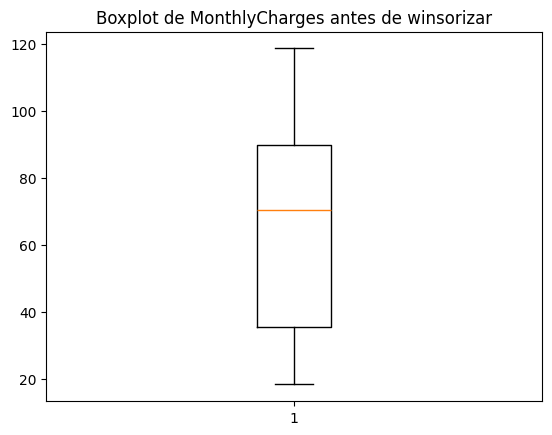

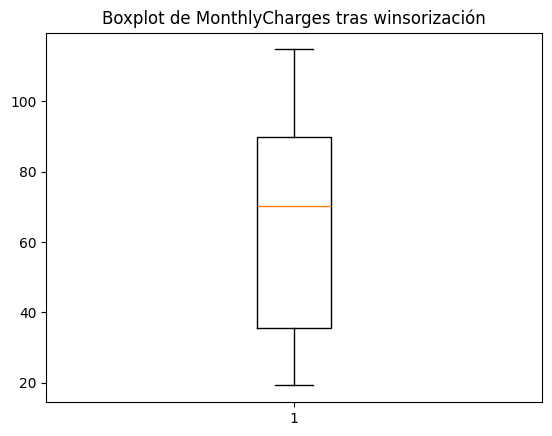

In [12]:
plt.boxplot(df["MonthlyCharges"])
plt.title("Boxplot de MonthlyCharges antes de winsorizar")
plt.show()

# Winsorización al 1° y 99° percentil
lower, upper = df["MonthlyCharges"].quantile([0.01, 0.99])
df["MonthlyCharges_w"] = df["MonthlyCharges"].clip(lower, upper)
plt.boxplot(df["MonthlyCharges_w"])
plt.title("Boxplot de MonthlyCharges tras winsorización")
plt.show()

## 5. Correcciones con replace/map

In [13]:
df["MultipleLines"] = df["MultipleLines"].replace("No phone service", "No")
print("   • Unique MultipleLines:", df["MultipleLines"].unique())

   • Unique MultipleLines: ['No' 'Yes']


## 6. Agregación de datos

In [14]:
servicios = ["PhoneService","OnlineSecurity","OnlineBackup",
             "DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
df["TotalServices"] = df[servicios].apply(lambda row: row.eq("Yes").sum(), axis=1)
print("   • Nueva columna TotalServices creada.")

   • Nueva columna TotalServices creada.


# III. VALIDACIÓN

## 1. Completitud de datos en columnas críticas

In [15]:
crit_cols = ["tenure","MonthlyCharges","TotalCharges","Churn"]
missing_crit = df[crit_cols].isnull().sum()
print("📋 Nulos en columnas críticas tras limpieza:")
print(missing_crit)

📋 Nulos en columnas críticas tras limpieza:
tenure            0
MonthlyCharges    0
TotalCharges      0
Churn             0
dtype: int64


## 2. Relevancia de variables

In [16]:
print("\n📈 Distribución de Churn (proporción clase objetivo):")
print(df["Churn"].value_counts(normalize=True))


📈 Distribución de Churn (proporción clase objetivo):
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


## 3. Granularidad adecuada

In [17]:
print(f"\n🔍 Nivel de granularidad final en tenure: {df['tenure'].nunique()} niveles")


🔍 Nivel de granularidad final en tenure: 73 niveles


# IV. Generar dataset limpio

## 7. Estandarización de variables categóricas

In [18]:
cat_cols = df.select_dtypes(include="object").columns.drop("customerID")  # Excluimos ID
df[cat_cols] = df[cat_cols].apply(lambda x: x.astype("category"))

## 8. Reorganización final de columnas

In [19]:
cols_order = ["customerID", "gender", "SeniorCitizen", "Partner", "Dependents", "tenure",
              "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
              "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
              "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod",
              "MonthlyCharges", "MonthlyCharges_w", "TotalCharges", "TotalServices", "Churn"]
df = df[cols_order]


## 9. Guardar el dataset limpio

In [20]:
df.to_csv("telco_clean.csv", index=False)
print("✅ Dataset limpio exportado como 'telco_clean.csv'")

✅ Dataset limpio exportado como 'telco_clean.csv'


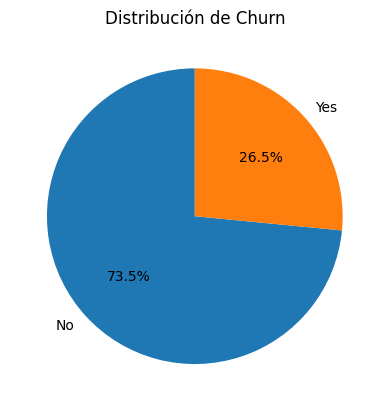

<Figure size 640x480 with 0 Axes>

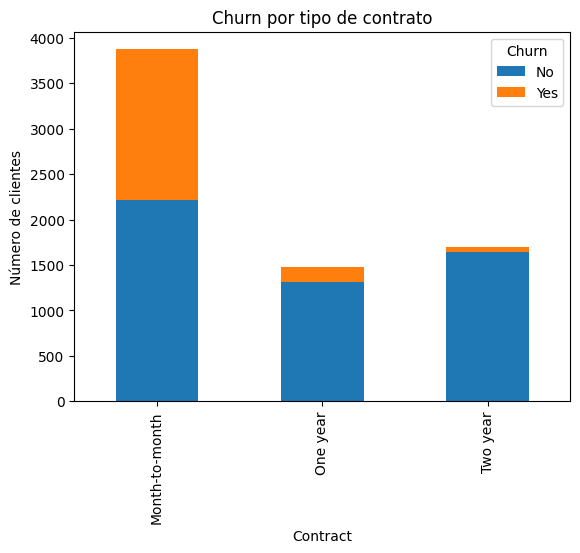

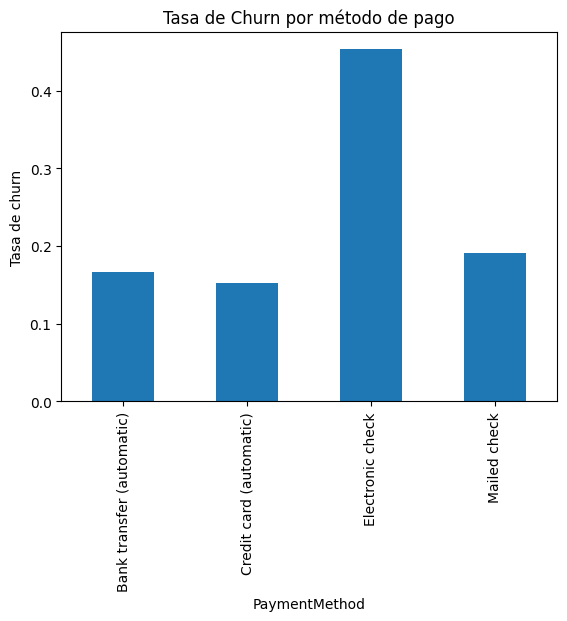

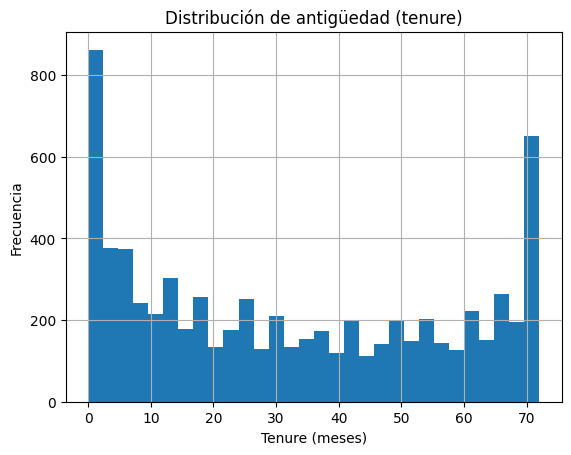

<Figure size 640x480 with 0 Axes>

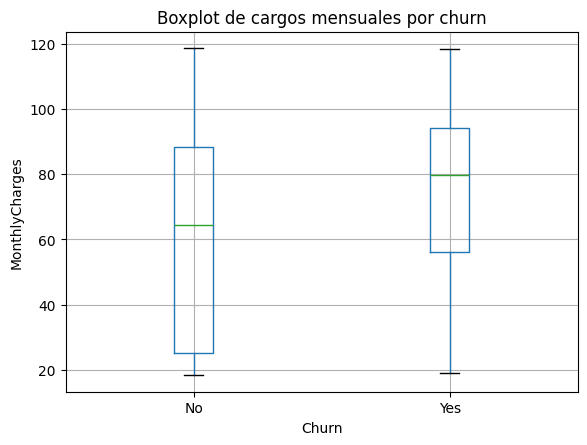

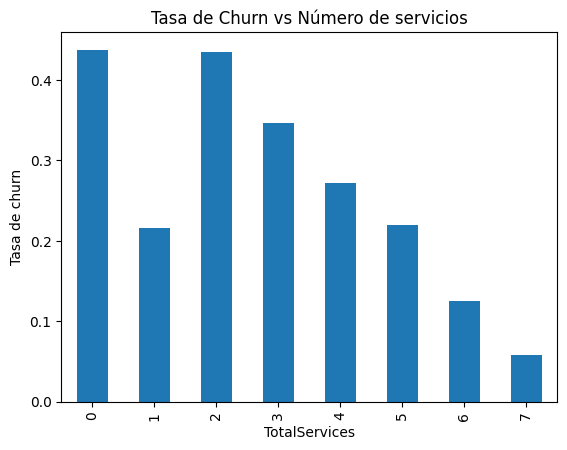

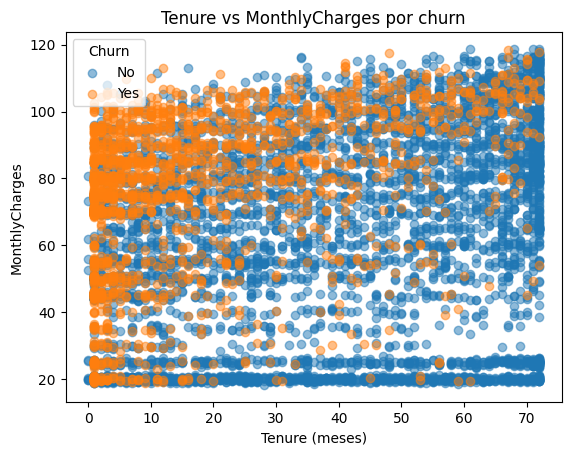

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Carga y limpieza mínima
df = pd.read_csv("telco_clean.csv")  # ó "WA_Fn-UseC_-Telco-Customer-Churn.csv" si no renombraste
# Asegúrate de haber corregido TotalCharges y creado TotalServices previamente
df["ChurnFlag"] = df["Churn"].map({"No": 0, "Yes": 1})

# 2. Distribución de Churn (Pie chart)
plt.figure()
df["Churn"].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Distribución de Churn")
plt.ylabel("")
plt.show()

# 3. Churn por tipo de contrato (Stacked bar)
contract_churn = df.groupby(["Contract","Churn"]).size().unstack(fill_value=0)
plt.figure()
contract_churn.plot(kind='bar', stacked=True)
plt.title("Churn por tipo de contrato")
plt.xlabel("Contract")
plt.ylabel("Número de clientes")
plt.show()

# 4. Tasa de Churn por método de pago (Bar chart)
payment_churn_rate = df.groupby("PaymentMethod")["ChurnFlag"].mean()
plt.figure()
payment_churn_rate.plot(kind='bar')
plt.title("Tasa de Churn por método de pago")
plt.xlabel("PaymentMethod")
plt.ylabel("Tasa de churn")
plt.show()

# 5. Distribución de tenure (Histograma)
plt.figure()
df["tenure"].hist(bins=30)
plt.title("Distribución de antigüedad (tenure)")
plt.xlabel("Tenure (meses)")
plt.ylabel("Frecuencia")
plt.show()

# 6. Cargos mensuales por Churn (Boxplot)
plt.figure()
df.boxplot(column="MonthlyCharges", by="Churn")
plt.title("Boxplot de cargos mensuales por churn")
plt.suptitle("")  # quita el subtítulo automático
plt.xlabel("Churn")
plt.ylabel("MonthlyCharges")
plt.show()

# 7. Tasa de Churn vs Número de servicios (Bar chart)
services_churn_rate = df.groupby("TotalServices")["ChurnFlag"].mean()
plt.figure()
services_churn_rate.plot(kind='bar')
plt.title("Tasa de Churn vs Número de servicios")
plt.xlabel("TotalServices")
plt.ylabel("Tasa de churn")
plt.show()

# 8. Relación Tenure vs MonthlyCharges por churn (Scatter)
plt.figure()
for label, group in df.groupby("Churn"):
    plt.scatter(
        group["tenure"],
        group["MonthlyCharges"],
        label=label,
        alpha=0.5
    )
plt.title("Tenure vs MonthlyCharges por churn")
plt.xlabel("Tenure (meses)")
plt.ylabel("MonthlyCharges")
plt.legend(title="Churn")
plt.show()
